# Quickstart

In this short tutorial we will guide you through a series of steps that will help you
getting started using **SDV**.

## 1. Model the dataset using SDV

To model a multi table, relational dataset, we follow two steps. In the first step, we will load
the data and configures the meta data. In the second step, we will use the sdv API to fit and
save a hierarchical model. We will cover these two steps in this section using an example dataset.

### Step 1: Load example data

**SDV** comes with a toy dataset to play with, which can be loaded using the `sdv.load_demo`
function:

In [1]:
from sdv import load_demo

metadata, tables = load_demo(metadata=True)

This will return two objects:

1. A `Metadata` object with all the information that **SDV** needs to know about the dataset.

In [2]:
metadata

Metadata
  root_path: /home/xals/Projects/MIT/SDV/tutorials
  tables: ['users', 'sessions', 'transactions']
  relationships:
    sessions.user_id -> users.user_id
    transactions.session_id -> sessions.session_id

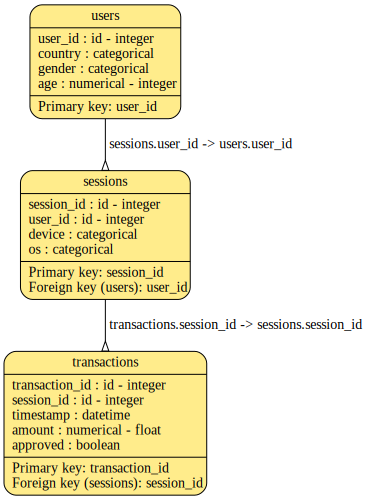

In [3]:
metadata.visualize()

For more details about how to build the `Metadata` for your own dataset, please refer to the
[Metadata](https://sdv-dev.github.io/SDV/metadata.html) section of the documentation.

2. A dictionary containing three `pandas.DataFrames` with the tables described in the
metadata object.

In [4]:
tables

{'users':    user_id country gender  age
 0        0     USA      M   34
 1        1      UK      F   23
 2        2      ES   None   44
 3        3      UK      M   22
 4        4     USA      F   54
 5        5      DE      M   57
 6        6      BG      F   45
 7        7      ES   None   41
 8        8      FR      F   23
 9        9      UK   None   30,
 'sessions':    session_id  user_id  device       os
 0           0        0  mobile  android
 1           1        1  tablet      ios
 2           2        1  tablet  android
 3           3        2  mobile  android
 4           4        4  mobile      ios
 5           5        5  mobile  android
 6           6        6  mobile      ios
 7           7        6  tablet      ios
 8           8        6  mobile      ios
 9           9        8  tablet      ios,
 'transactions':    transaction_id  session_id           timestamp  amount  approved
 0               0           0 2019-01-01 12:34:32   100.0      True
 1               1  

### 2. Fit a model using the SDV API.

First, we build a hierarchical statistical model of the data using **SDV**. For this we will
create an instance of the `sdv.SDV` class and use its `fit` method.

During this process, **SDV** will traverse across all the tables in your dataset following the
primary key-foreign key relationships and learn the probability distributions of the values in
the columns.

In [5]:
from sdv import SDV

sdv = SDV()
sdv.fit(metadata, tables)

2020-07-09 20:57:19,919 - INFO - modeler - Modeling users
2020-07-09 20:57:19,920 - INFO - __init__ - Loading transformer CategoricalTransformer for field country
2020-07-09 20:57:19,920 - INFO - __init__ - Loading transformer CategoricalTransformer for field gender
2020-07-09 20:57:19,921 - INFO - __init__ - Loading transformer NumericalTransformer for field age
2020-07-09 20:57:19,933 - INFO - modeler - Modeling sessions
2020-07-09 20:57:19,934 - INFO - __init__ - Loading transformer CategoricalTransformer for field device
2020-07-09 20:57:19,934 - INFO - __init__ - Loading transformer CategoricalTransformer for field os
2020-07-09 20:57:19,944 - INFO - modeler - Modeling transactions
2020-07-09 20:57:19,944 - INFO - __init__ - Loading transformer DatetimeTransformer for field timestamp
2020-07-09 20:57:19,944 - INFO - __init__ - Loading transformer NumericalTransformer for field amount
2020-07-09 20:57:19,945 - INFO - __init__ - Loading transformer BooleanTransformer for field appro

## 2. Sample data from the fitted model

Once the modeling has finished you are ready to generate new synthetic data using the `sdv` instance that you have.

For this, all you have to do is call the `sample_all` method from your instance passing the number of rows that you want to generate:

In [6]:
sampled = sdv.sample_all(10)

This will return a dictionary identical to the `tables` one that we passed to the SDV instance for learning, filled in with new synthetic data.

**Note** that only the parent tables of your dataset will have the specified number of rows,
as the number of child rows that each row in the parent table has is also sampled following
the original distribution of your dataset.

In [7]:
sampled['users']

,user_id,country,gender,age
0,0,UK,NaN,39
1,1,UK,F,27
2,2,UK,NaN,50
3,3,USA,F,29
4,4,UK,NaN,21
5,5,ES,NaN,27
6,6,UK,F,20
7,7,USA,F,15
8,8,DE,F,41
9,9,ES,F,35


In [8]:
sampled['sessions'].head(10)

,session_id,user_id,device,os
0,0,1,mobile,android
1,1,2,tablet,ios
2,2,2,tablet,ios
3,3,2,mobile,android
4,4,3,mobile,android
5,5,5,mobile,android
6,6,5,mobile,android
7,7,5,tablet,ios
8,8,6,tablet,ios
9,9,6,mobile,android


In [9]:
sampled['transactions'].head(10)

,transaction_id,session_id,timestamp,amount,approved
0,0,0,2019-01-13 01:11:06.084275968,80.350553,True
1,1,0,2019-01-13 01:11:06.368704256,82.116470,True
2,2,1,2019-01-25 15:05:07.735262976,97.616590,True
3,3,1,2019-01-25 15:05:09.098958848,96.505258,True
4,4,2,2019-01-25 15:05:09.124231424,97.235452,True
5,5,2,2019-01-25 15:05:07.347315456,96.615923,True
6,6,3,2019-01-25 15:05:09.190441984,97.173195,True
7,7,3,2019-01-25 15:05:07.437910784,96.995037,True
8,8,0,2019-01-13 01:11:06.560940032,81.027625,True
9,9,1,2019-01-25 15:05:12.420746496,97.340054,True


## Saving and Loading your model

In some cases, you might want to save the fitted SDV instance to be able to generate synthetic data from
it later or on a different system.

In order to do so, you can save your fitted `SDV` instance for later usage using the `save` method of your
instance.

In [10]:
sdv.save('sdv.pkl')

The generated `pkl` file will not include any of the original data in it, so it can be
safely sent to where the synthetic data will be generated without any privacy concerns.

Later on, in order to sample data from the fitted model, we will first need to load it from its
`pkl` file.

In [11]:
sdv = SDV.load('sdv.pkl')

After loading the instance, we can sample synthetic data using its `sample_all` method like before.

In [12]:
sampled = sdv.sample_all(5)